The result of the previous attempt at solving this matching problem was ambiguous, and ultimately not helpful. Phone matching, while easy and convenient, fundamentally failed to work well enough, both for real-life reasons and for statistical reasons, for the resultant dataset to be particularly informative.

This notebook begins a fresh attempt at this project. This time around we will try to use the Yelp! search API instead of the the Yelp phone API. In the previous iteration the search API proved to be not very good at matching location placenames against actual locations. Howevever, I realize now that this isn't a helpful match to attempt anyway, because:

1. There are obviously multiple restaurants in New York City with names like `Burger King` or `Dunkin' Donuts`.
2. There is no way to tell if a match failure occurs because of fuzzy matching issues or because the location no longer exists, within the time frame of Yelp! data.

I am no longer using the restaurant inspection data, either; I've switched now to using the [DOHMH Food Permit](https://data.cityofnewyork.us/City-Government/DOHMH-Food-Permits/mphz-k8gq) dataset. This dataset contains every food permit issued by the DOHMH going some uncertain number of years back. Each food permit realiably indicates a single restaurant opening (more information on food permits [here](https://www1.nyc.gov/nycbusiness/description/food-service-establishment-permit); more information on restaurant start structuring [here](http://www.nyc.gov/html/nycbe/downloads/pdf/nycstarter_guide_restaurant.pdf)), and multiple food permits issued in the same location (address-wise) reliably indicates a history of start dates for restaurants opened at the location (but *only* of restaurants; intervening businesses are untracable).


Yelp should also be much better at matching *addresses* than at doing any of the previous things I had tried to do.

In [1]:
import pandas as pd

In [2]:
permits = pd.read_csv("https://data.cityofnewyork.us/api/views/mphz-k8gq/rows.csv?accessType=DOWNLOAD")

/Users/Honors/anaconda/envs/nyc-restaurant-trends/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (2,9,13,15,16,17,18,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
len(permits)

304387

In [4]:
permits.sample(1)

,Source,License_Permit_Holder,Business_Description,License/Permit_Number,Permit_Type_Description,Permit_Subtype_Description,Permit_Issuance_Date,Permit_Expiration_Date,Permit_Status_Date,Permit_Status_Description,...,City,Zip_Code,Borough,Building_ID_No,Borough_Block_Lot,Latitude_WGS84,Longitude_WGS84,License/Permit_Holder_Name,DOB_Skilled_Trades_Lic_Num,DOB_Skilled_Trades_Lic_Type
283792,DOHMH Permit,MVNBC CORP.,NaN,1341855.0,RETAIL FOOD PROCESS,FOOD SERVICE ESTABL WITH MFD MACHINE,10/24/2012 00:00:00,12/31/2014 00:00:00,01/17/2014 00:00:00,NaN,...,NEW YORK,10013,MANHATTAN,1002072,1001810013,40.719300,-74.010018,Unknown,NaN,NaN


In [5]:
import numpy as np

The data appears to go *very* far back and are completely full, but not all in one date format and plenty of errors thrown into the mix.

In [6]:
np.unique(permits['Permit_Issuance_Date'])

array(['01/01/1900 00:00:00', '01/02/1992 00:00:00', '01/02/1996 00:00:00',
       ..., '2013-05-29', '2013-05-30', '2013-06-06'], dtype=object)

In [7]:
permits['Permit_Issuance_Date'].isnull().any()

False

In [8]:
permits['Permit_Issuance_Date'].value_counts(dropna=False)

01/01/1900 00:00:00    62429
1900-01-01             18642
11/08/2012 00:00:00     1048
05/21/2012 00:00:00      913
06/09/1994 00:00:00      802
07/01/1992 00:00:00      772
05/11/1995 00:00:00      740
07/15/1991 00:00:00      734
07/02/2012 00:00:00      693
06/04/2012 00:00:00      686
03/19/2013 00:00:00      646
09/04/2012 00:00:00      625
07/17/2012 00:00:00      579
07/30/2012 00:00:00      575
1994-06-09               562
07/31/2012 00:00:00      553
12/26/2012 00:00:00      542
03/12/2013 00:00:00      541
08/27/2012 00:00:00      537
04/12/2012 00:00:00      536
10/01/2012 00:00:00      536
1991-07-15               530
07/19/2012 00:00:00      523
10/22/2012 00:00:00      522
04/30/2012 00:00:00      514
07/05/2012 00:00:00      514
02/05/2013 00:00:00      511
10/30/1995 00:00:00      511
09/10/2012 00:00:00      497
09/24/2012 00:00:00      492
                       ...  
11/07/2002 00:00:00        1
2004-01-29                 1
2013-04-16                 1
1993-01-13    

Checking data nullity:

In [9]:
permits.apply(lambda col: col.isnull().astype(int).sum())

Source                              0
License_Permit_Holder           18427
Business_Description           301452
License/Permit_Number           42027
Permit_Type_Description             0
Permit_Subtype_Description          0
Permit_Issuance_Date                0
Permit_Expiration_Date              0
Permit_Status_Date                  0
Permit_Status_Description      299624
Address                             0
Street                              0
City                                0
Zip_Code                           27
Borough                             0
Building_ID_No                      0
Borough_Block_Lot                   0
Latitude_WGS84                    691
Longitude_WGS84                   691
License/Permit_Holder_Name        127
DOB_Skilled_Trades_Lic_Num     304384
DOB_Skilled_Trades_Lic_Type    304384
dtype: int64

In [10]:
permits.apply(lambda col: col.isnull().astype(int).sum()) / len(permits)

Source                         0.000000
License_Permit_Holder          0.060538
Business_Description           0.990358
License/Permit_Number          0.138071
Permit_Type_Description        0.000000
Permit_Subtype_Description     0.000000
Permit_Issuance_Date           0.000000
Permit_Expiration_Date         0.000000
Permit_Status_Date             0.000000
Permit_Status_Description      0.984352
Address                        0.000000
Street                         0.000000
City                           0.000000
Zip_Code                       0.000089
Borough                        0.000000
Building_ID_No                 0.000000
Borough_Block_Lot              0.000000
Latitude_WGS84                 0.002270
Longitude_WGS84                0.002270
License/Permit_Holder_Name     0.000417
DOB_Skilled_Trades_Lic_Num     0.999990
DOB_Skilled_Trades_Lic_Type    0.999990
dtype: float64

We need to clean up these dates. First of all, what does the complete pile of options look like?

In [11]:
# print(list(np.unique(permits['Permit_Issuance_Date'])))

It looks like, with the exception of a single error (`'05/30ription":"The date on which a legal agreement becomes effective, or is expected to become effective.'`), all of the dates are in one of two formats: `'2013-06-06'` or `'11/22/1999 00:00:00'`.

**Note**: The text in the errenous line comes from the description attached to the permit issuance date field on the Socrata portal, and has nothing to do with the underlying data itself. This means that it is almost certainly an error with the Socrata portal software. Furthermore, I have seen this error or a very similar error crop up in a large number of the portal datasets I have worked with, indicating that this is some sort of recurrant defficiency within Socrata itself. Maybe this issue ought to be raised somewhere? It's an unneeded difficulty.

In [12]:
permits[permits['Permit_Issuance_Date'] == """05/30ription":"The date on which a legal agreement becomes effective, or is expected to become effective."""]

,Source,License_Permit_Holder,Business_Description,License/Permit_Number,Permit_Type_Description,Permit_Subtype_Description,Permit_Issuance_Date,Permit_Expiration_Date,Permit_Status_Date,Permit_Status_Description,...,City,Zip_Code,Borough,Building_ID_No,Borough_Block_Lot,Latitude_WGS84,Longitude_WGS84,License/Permit_Holder_Name,DOB_Skilled_Trades_Lic_Num,DOB_Skilled_Trades_Lic_Type
7528,DOHMH Permit,PADDA PIZZA & RESTURANT INC,NaN,1040957.0,FOOD SERVICE EST.,FOOD SERVICE ESTABL.,"05/30ription"":""The date on which a legal agree...","fieldName"":""effective_date_most_recent_","position"":28","tableColumnId"":1472092",...,"align"":""left""}","metadata"":{}}","{""id"":140605801","name"":""Closed Date (Most Recent)","dataTypeName"":""calendar_date","description"":""The date specified in the legal ...","fieldName"":""closed_date_most_recent_","position"":29","tableColumnId"":1472093","width"":203"


Looks like we'll just have to drop this entry, because it's unusable.

In [13]:
permits = permits.drop(7528)

In [14]:
len(permits)

304386

The rest of the dates in this column ought to be handleable with `pd.to_datetime()`.

But it fails! How come?

In [15]:
from tqdm import tqdm_notebook, tqdm_pandas
tqdm_pandas(tqdm_notebook())

In [16]:
permits['Permit_Issuance_Date'] = permits['Permit_Issuance_Date'].progress_map(lambda date: pd.to_datetime(date))

**Note**: Here I attempted to use a `tqdm_notebook` callback, something I've never done before. It works great! To help detect where in the loop the date failure occured, if one does, the loop iteration returned to me ought to be helpful as well. However, `tqdm` operates using occassional polling, so it doesn't *exactly* track the iteration a process is on when it fails (at least, in the case of fast functions, as here; in the case of slow ones with low variability, like e.g. API calls, the number ought be faithful). Good to know!

It turns out that [food permits expire](http://www1.nyc.gov/nyc-resources/faq/425/how-do-i-renew-my-restaurant-permit) and require approximately yearly renewal! That's fantastic, and not something I knew going into this.

Let's format our expiry dates.

In [17]:
permits['Permit_Expiration_Date'].isnull().any()

False

At first I tried to run `np.datetime` as-is on this data, but this again failed near the end. The following list reveals the culprit:

In [18]:
# print(list(np.unique(permits['Permit_Expiration_Date'])))

In [19]:
permits[permits['Permit_Expiration_Date'] == """11/30/2016 00:00:00cts from the five boroughs of New York City (Brooklyn, Kings, New York, Queens, and Richmond). BOCES, special act schools (4201 designated schools), charter, and private schools are also excluded."}"""]

,Source,License_Permit_Holder,Business_Description,License/Permit_Number,Permit_Type_Description,Permit_Subtype_Description,Permit_Issuance_Date,Permit_Expiration_Date,Permit_Status_Date,Permit_Status_Description,...,City,Zip_Code,Borough,Building_ID_No,Borough_Block_Lot,Latitude_WGS84,Longitude_WGS84,License/Permit_Holder_Name,DOB_Skilled_Trades_Lic_Num,DOB_Skilled_Trades_Lic_Type
266169,DOHMH Permit,Abegale's Inc,NaN,NaN,RETAIL FOOD PROCESS,FOOD SERVICE ESTABL WITH MFD MACHINE,1900-01-01,11/30/2016 00:00:00cts from the five boroughs ...,"Additional Resources"":{""See Also "":""","See Also "":""",...,"See Also "":""","See Also "":""","See Also "":""","See Also"":""http://www.health.ny.gov/statistics...","See Also "":""","See Also "":""""}","Dataset Information"":{""Agency"":""Health, Depart...","renderTypeConfig"":{""visible"":{""chart"":true","table"":true}}","availableDisplayTypes"":[""chart"


In [20]:
permits = permits.drop(266169)

Not a fan of this crap, Socrata.

In [21]:
permits['Permit_Expiration_Date'] = permits['Permit_Expiration_Date'].progress_map(lambda date: pd.to_datetime(date))

That should be enough.

Source is as expected:

In [22]:
permits['Source'].value_counts()

DOHMH Permit    304385
Name: Source, dtype: int64

`Business_Description` is mostly empty, and contains the following in the non-empty entries:

In [23]:
permits[permits['Business_Description'].notnull()]['Business_Description'].value_counts()

DOH-TRIBUNAL-ENTITY           979
DOH-MULITPLE DWELLING         867
DOH PRIVATE DWELLING          541
DOH-VACANT LOT -ENTITY        209
MUTIPLE DWELLING COMERCIAL    167
MISC FOOD STORE                61
COMMERCIAL BUILDING -DOH       40
DELICATESSEN                   19
GROCERY-RETAIL                 13
DRUG STORE-RETAIL               6
CONSUMER SVC-RETAIL             6
DOH-OFFICE BUILDING             6
MISC NON-FOOD RETAIL            5
GAS STATION-RETAIL              5
BAKERY-RETAIL                   5
TOBACCO PRODUCT SALES           3
SUPERMARKET                     2
MISC FOOD WHLSALE               1
Name: Business_Description, dtype: int64

In [24]:
permits['Permit_Type_Description'].value_counts()

FOOD SERVICE EST.       204464
TEMP FOOD SERV ESTAB     33497
RETAIL FOOD PROCESS      24909
FOOD VENDOR LICENSE      16199
FOOD SERVICE ESTAB       15585
MOBILE FOOD UNIT          5144
NONRETAIL FOOD ESTAB      1757
FOOD SVC ESTAB. NON       1707
FOOD SERVICE ESTAB.       1074
FOOD SERVICE ESTABL.        31
MOBILE FOOD PERMIT          17
NYS FACILITY FOODSVC         1
Name: Permit_Type_Description, dtype: int64

What's the one NYS FACLITY FOODSVC?

In [25]:
permits[permits['Permit_Type_Description'] == 'NYS FACILITY FOODSVC']

,Source,License_Permit_Holder,Business_Description,License/Permit_Number,Permit_Type_Description,Permit_Subtype_Description,Permit_Issuance_Date,Permit_Expiration_Date,Permit_Status_Date,Permit_Status_Description,...,City,Zip_Code,Borough,Building_ID_No,Borough_Block_Lot,Latitude_WGS84,Longitude_WGS84,License/Permit_Holder_Name,DOB_Skilled_Trades_Lic_Num,DOB_Skilled_Trades_Lic_Type
177958,DOHMH Permit,Rivera Sales Enterprises INC,NaN,NaN,NYS FACILITY FOODSVC,NYS FACILITY WITH FOOD SERVICE,1900-01-01,2015-06-30,04/30/2014 00:00:00,NaN,...,BRONX,10456,BRONX,2004358,2026190010,40.8221,-73.9094,Unknown,NaN,NaN


Nothing interesting.

We are interested in permanent restaurant establishments. So let's subselect our data to match that expectation.

In [26]:
restaurant_permits = permits[permits['Permit_Type_Description'].isin(['FOOD SERVICE EST.', 'FOOD SERVICE ESTAB.', 'FOOD SERVICE ESTABL.'])]

In [27]:
len(restaurant_permits)

205569

`Permit_Subtype_Description` provides some additional context.

In [28]:
permits['Permit_Subtype_Description'].value_counts()

FOOD SERVICE ESTABL.                        204464
TEMP FOOD SERV ESTABSTREET FAIR NONPROC      30570
FOOD SERVICE ESTABL WITH MFD MACHINE         24909
FOOD SERVICE        ESTABLISHMENT            14420
FOOD VENDOR LICENSE SEASONAL RENEWAL         11230
SEASONAL MFV PERMIT NONPROCESSING             5144
FOOD VENDOR LICENSE FULL TERM RNW FEE-EX      4307
TEMP FOOD SERV ESTAB STREET FAIR              2801
FOOD SVC ESTAB. NON PUBLIC SCHL/FRAT ORG      1140
FOOD SERVICE ESTAB. FOOD RELIEF ORGANIZ.      1074
FOOD SERVICE ESTAB  SENIOR CENTER             1067
NONRETAIL FOOD ESTAB                           782
NONRETAIL FOOD ESTABVENDOR COMMISS/DEPOT       768
FOOD VENDOR LICENSE FULL TERM NEW FEE-EX       480
FOOD SVC ESTAB. NON PUBLIC SCHOOL/PROFIT       302
FOOD SVC ESTAB. NON PUBLIC SCHOOL/BD ED        265
NONRETAIL FOOD ESTABFISH OR SHELLFISH          205
FOOD VENDOR LICENSE SEASONAL NEW               141
TEMP FOOD SERV ESTABSTREET FAIR NO-FEE         126
FOOD SERVICE ESTAB. FRAT/CHARIT

What's interesting is that when we cut to restaurants specifically we get far fewer types, which makes sense:

In [29]:
restaurant_permits['Permit_Subtype_Description'].value_counts()

FOOD SERVICE ESTABL.                        204464
FOOD SERVICE ESTAB. FOOD RELIEF ORGANIZ.      1074
FOOD SERVICE ESTABL.FRATERNAL,CHARIT ORG        31
Name: Permit_Subtype_Description, dtype: int64

The latter two classes are really the same thing, probably. Interesting to see ~0.5% of food establishments in New York City could be called chariatable. 

In [30]:
restaurant_permits.head(10)

,Source,License_Permit_Holder,Business_Description,License/Permit_Number,Permit_Type_Description,Permit_Subtype_Description,Permit_Issuance_Date,Permit_Expiration_Date,Permit_Status_Date,Permit_Status_Description,...,City,Zip_Code,Borough,Building_ID_No,Borough_Block_Lot,Latitude_WGS84,Longitude_WGS84,License/Permit_Holder_Name,DOB_Skilled_Trades_Lic_Num,DOB_Skilled_Trades_Lic_Type
0,DOHMH Permit,HOT JALAPENO RESTAURANT CORP.,NaN,1447631.0,FOOD SERVICE EST.,FOOD SERVICE ESTABL.,2012-10-22,2013-10-31,10/22/2012 00:00:00,NaN,...,NEW YORK,10029,MANHATTAN,1052570,1016660008,40.797814,-73.938961,"MEJIA, JAMIE E.",NaN,NaN
1,DOHMH Permit,RIGHT TASTE RESTAURANT INC,NaN,1446867.0,FOOD SERVICE EST.,FOOD SERVICE ESTABL.,2013-01-23,2013-10-31,01/23/2013 00:00:00,NaN,...,BRONX,10466,BRONX,2064799,2048680052,40.891093,-73.850918,"ERROL, SPENCER",NaN,NaN
2,DOHMH Permit,CHORSU CORP,NaN,1304742.0,FOOD SERVICE EST.,FOOD SERVICE ESTABL.,2012-10-11,2013-11-30,10/11/2012 00:00:00,NaN,...,BROOKLYN,11223,BROOKLYN,3177125,3066570053,40.604511,-73.972778,"MAKHMUDOV, MUMIN",NaN,NaN
3,DOHMH Permit,561 SOUTHERN FOOD CORP.,NaN,1235037.0,FOOD SERVICE EST.,FOOD SERVICE ESTABL.,2012-08-28,2013-08-31,10/26/2012 00:00:00,NaN,...,BRONX,10455,BRONX,2088194,2026830045,40.812702,-73.903234,"DELGADO-MORALES, MARDOMIO ROBERTO",NaN,NaN
4,DOHMH Permit,BBQ CHICKEN DON ALEX NO 1 CORP,NaN,1447036.0,FOOD SERVICE EST.,FOOD SERVICE ESTABL.,2013-03-12,2013-10-31,03/11/2013 00:00:00,NaN,...,LONG ISLAND CITY,11101,QUEENS,4036228,4014720001,40.749762,-73.881945,"DIAVIM, M. OSORES",NaN,NaN
5,DOHMH Permit,PETER'S GINZA INC,NaN,1448608.0,FOOD SERVICE EST.,FOOD SERVICE ESTABL.,2012-11-26,2013-10-31,11/26/2012 00:00:00,NaN,...,FLUSHING,11358,QUEENS,4135004,4060740037,40.766485,-73.789454,"MYUNGSHIN, JUN",NaN,NaN
6,DOHMH Permit,ROYAL SUBS CORP.,NaN,1447151.0,FOOD SERVICE EST.,FOOD SERVICE ESTABL.,2012-10-22,2013-10-31,10/22/2012 00:00:00,NaN,...,BROOKLYN,11228,BROOKLYN,3159989,3062220001,40.619698,-74.007698,"ROAY, KOHLI",NaN,NaN
7,DOHMH Permit,ABSOLUTELYDIVINECOOKIES.COM LLC,NaN,1446900.0,FOOD SERVICE EST.,FOOD SERVICE ESTABL.,2012-10-11,2013-10-31,10/11/2012 00:00:00,NaN,...,WOODSIDE,11377,QUEENS,4031760,4013430146,40.743163,-73.898654,"ROA, MARIBETH",NaN,NaN
8,DOHMH Permit,EASY CORNER RESTAURANT & GRILL INC.,NaN,1447792.0,FOOD SERVICE EST.,FOOD SERVICE ESTABL.,1900-01-01,2013-10-31,10/19/2012 00:00:00,NaN,...,NEW YORK,10026,MANHATTAN,1058330,1019210029,40.815025,-73.940644,"EPPS, FATIMA",NaN,NaN
9,DOHMH Permit,"LAS TIAS BAKERY, LLC",NaN,1413166.0,FOOD SERVICE EST.,FOOD SERVICE ESTABL.,2012-09-18,2014-11-30,09/09/2013 00:00:00,NaN,...,MIDDLE VILLAGE,11379,QUEENS,4071753,4030650012,40.713058,-73.878287,Unknown,NaN,NaN


As before, `1900-01-01` is a sentinel value for "unknown" (hence the entries with `41576` or thereabout permit time). The rest of the permits issued are usually around a year in extent, but with a great degree of variability: 

In [31]:
restaurant_permits['Permit_Expiration_Date'] - restaurant_permits['Permit_Issuance_Date']

0          374 days
1          281 days
2          415 days
3          368 days
4          233 days
5          339 days
6          374 days
7          385 days
8        41576 days
9          803 days
13       41576 days
15         281 days
17         226 days
18         357 days
19         357 days
20         337 days
21         357 days
22       41576 days
23         245 days
28         316 days
30         431 days
31         267 days
32       41545 days
33       41576 days
34         281 days
35         233 days
36         309 days
37       41576 days
38         268 days
40         374 days
            ...    
304345   42976 days
304346   42183 days
304347   41910 days
304349   42976 days
304351   42306 days
304352   34148 days
304353   42306 days
304354   35609 days
304355   42275 days
304356   42122 days
304357   42092 days
304358   42672 days
304360   42672 days
304365   42884 days
304366   42884 days
304368   42914 days
304369   42702 days
304370   42488 days
304372   42914 days


In [46]:
permit_times = (restaurant_permits['Permit_Expiration_Date'] - restaurant_permits['Permit_Issuance_Date']) 
permit_times = permit_times[(permit_times < pd.to_timedelta(30000, unit='d')) & (pd.to_timedelta(0, unit='d') < permit_times)]

In [47]:
len(permit_times) / len(restaurant_permits)

0.6845292821388439

So only ~70% of records have both valid issuance and permit dates.

In [34]:
import seaborn as sns
%matplotlib inline

In [48]:
permit_times[:10].map(lambda d: d.days)

0     374
1     281
2     415
3     368
4     233
5     339
6     374
7     385
9     803
15    281
dtype: int64

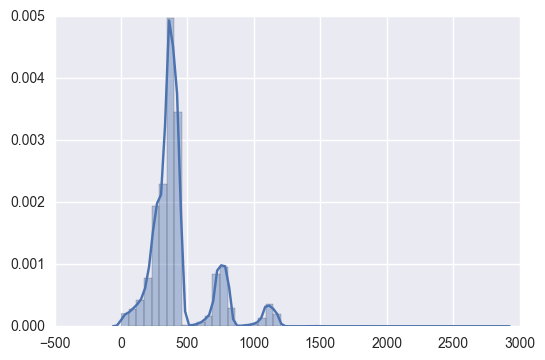

In [49]:
sns.distplot(permit_times.map(lambda d: d.days))

Permit times of a year are clearly heavily favored, but far from universial.

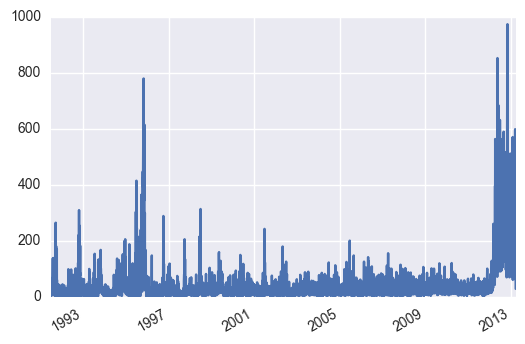

In [74]:
permit_issuance_counts = restaurant_permits['Permit_Issuance_Date'].value_counts().sort_index()[1:]
permit_issuance_counts.plot()

Another dead end! This data, it turns out, actually cuts out in early 2013.

Looks this is an undeclared unupdated one-time dump. Ridiculous!